### Roomba movement simulation

#### Assumptions

1) Our robot is holonomic with two degrees of freedom. It can move forward and backward in the North-South axis or the East-West axis.

2) Our robot can only move one axis at the time. 

3) We represent the entirety of the room in which the robot operates as a grid. In any given time step the robot will move one tile in one axis, hence it can visit any of it's Von Neumann neighbors (it can not move diagonally in the grid). 

4) The robot will clean whatever tile in which it is currently located at every time step. Note that a more complex could choose not to clean it's current tile at some time step (which would correspond to saving energy or moving faster) which would allow for a more complex analysis of strategies




In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.cm as cm
% matplotlib notebook
#%matplotlib inline 
import numpy as np
import random
from scipy import stats
from IPython.display import HTML

import base64
try:
    base64.encodebytes
except AttributeError:
    base64.encodebytes = base64.encodestring

In [78]:
class grid_map:
    def __init__(self, n = 10, obst_dens = 0.15, time = 0, dir_ind = None, sensor_std = 1):
        self.n = n
        self.obst_dens = obst_dens
        self.grid = np.zeros(shape = (n,n))
        self.time = 0
        self.dir_ind = dir_ind
        self.dir_list = [[1,0],[0,1],[-1,0],[0,-1]]
        #make walls at the borders
        for i in range(n): 
            self.grid[0,i] = -100
            self.grid[i,0] = -100
            self.grid[n-1,i] = -100
            self.grid[i,n-1] = -100
        self.random_obstacles()
        self.place_robot()
        #std for gaussian sensor noise
        self.sensor_std = sensor_std
    
    def random_obstacles(self):
        for i in range(1, self.n - 1):
            for j in range(1, self.n - 1):
                if random.random() < self.obst_dens and self.grid[i,j] == 0: self.grid[i,j] = -100
                    
                    
    def place_robot(self):
        placed = False
        while not placed:
            i, j  = random.randint(1, self.n - 1), random.randint(1, self.n - 1)
            if self.grid[i,j] == 0: 
                self.pos = [i,j]
                placed = True
                                
     
    def random_walk(self, pos = None, particle = False):
        #try random directions until we find a free one
        if not pos: pos = self.pos[:]
        moved = False
        while not moved:
            self.dir_ind = random.randint(0, len(self.dir_list) - 1)
            x, y = pos[0] + self.dir_list[self.dir_ind][0], pos[1] + self.dir_list[self.dir_ind][1]
            #check if free
            if self.grid[x,y] >= 0: 
                pos = [x,y]
                if not particle: self.grid[x,y] += 1
                if not particle: self.time += 1
                moved = True
        return pos        
               
    
    def random_bounce(self, pos = None, particle = False):
        #Similar to random walk, but we first try to move in the same direction we moved before
        if not pos: pos = self.pos
        moved = False
        if not self.dir_ind: self.dir_ind = random.randint(0, len(self.dir_list) - 1)
        while not moved:            
            x, y = pos[0] + self.dir_list[self.dir_ind][0], pos[1] + self.dir_list[self.dir_ind][1]
            #check if free
            if self.grid[x,y] >= 0: 
                pos = [x,y]
                if not particle: self.grid[x,y] += 1
                if not particle: self.time += 1
                moved = True
            #we want to keep the same direction unless we can't move there
            if not moved: self.dir_ind = random.randint(0, len(self.dir_list) - 1)
        return pos
    
    
    def sensor_distance(self, pos = None, noise = True):
        #function to measure the distance from the robot to the neares wall/obstacle
        #We obtain distances in the 4 directions perpendicular to the robot's walls (cardinal directions)
        if not pos: pos = self.pos
        distances = []
        for dir_ind in range(4):
            this_dir = np.asarray(self.dir_list[dir_ind])
            dist = 1
            check_pos  = np.asarray(pos) + this_dir * dist
            while self.grid[check_pos[0], check_pos[1]] >= 0:
                dist += 1
                check_pos = np.asarray(pos) + this_dir * dist
            distances.append(dist)
        #Add noise
        if noise:
            for i in range(len(distances)):
                distances[i] += np.random.normal(scale = self.sensor_std)
        return distances
    
    def observe(self, X = None):
        plt.clf() 
        #Check if we are displaying particle filtering
        if X:
            #add some noice so particles don't overlap completely
            for i in range(len(X)):
                plt.scatter(X[i][1] + np.random.normal(0,0.15),
                            X[i][0] + np.random.normal(0,0.15), c='b') 
        plt.scatter(self.pos[1], self.pos[0], c='r')
        plt.title('timestep : %s'%self.time)
        plt.imshow(self.grid, cmap= cm.viridis, interpolation='none')
        plt.show()
        
    
    def particle_filtering(self, X = None, W = None, particles = 200, steps = 1):
        #Initial sample:
        if not W: W = [1.0/particles for _ in range(particles)]
        if not X:         
            X = []
            for _ in range(particles):
                valid = False
                while not valid:
                    x, y = random.randint(0,self.n-1), random.randint(0,self.n-1)
                    if self.grid[x,y] >= 0:
                        valid = True
                        X.append([x,y])                
            return X, W
        
        for i in range(steps):
            #sample points
            X_ind = np.random.choice([j for j in range(particles)], p= W, size = particles, replace = True)
            X_prime = [X[j] for j in X_ind]
            #update points based on motion model  
            #if motion is not deterministic, we are basically sampling from P(X'|X) 
            for i in range(particles):
                X_prime[i] = self.random_walk(pos = X_prime[i], particle = True)
            #Move robot and obtain sensor measurements
            self.pos = self.random_walk()
            sensors = self.sensor_distance()            
            #Finally, we update weights. w = P(Observed| Real)
            for i in range(particles):
                particle_distances = self.sensor_distance(pos = X_prime[i], noise = False)
                w = 1                
                for j in range(4):
                    w *= stats.norm.pdf(sensors[j] , 
                                        loc = particle_distances[j], scale = self.sensor_std)
                W[i] = w
            N =  sum(W)
            W = [w/N for w in W]
                
        return X_prime, W      
            
    
    #Remove obstacles from array so we can measure performance
    def tiles(self):
        flat = np.ndarray.flatten(self.grid)
        out = []
        for tile in flat:
            if tile >= 0:
                out.append(tile)
        return np.asarray(out)                    

In [5]:
#Gini coefficient calculating function taken from: https://github.com/oliviaguest/gini

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

##  Random Walk Strategy

We can run this animation to see the behaviour of our robot under a random walk strategy.

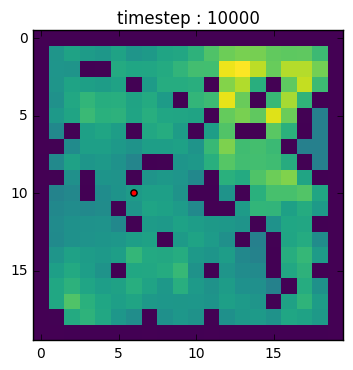

[2.9279193753027406, 5.39049851394167, 0.7843320993962783, 4.200354630772047]

In [28]:
Sim = grid_map(n = 20, obst_dens = 0.15)
for i in range(10000):
    Sim.pos = Sim.random_walk()
Sim.observe()
Sim.sensor_distance()

<IPython.core.display.Javascript object>


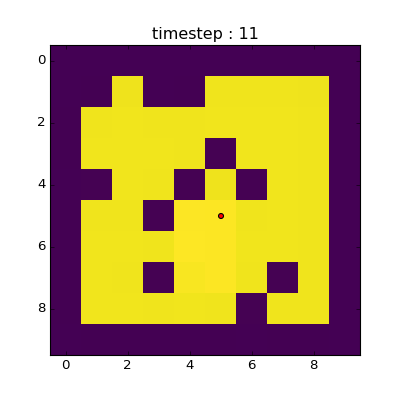

In [8]:
def animate(i):
    for t in  range(1):
        Sim.pos = Sim.random_walk()
    return(Sim.observe())
    
Sim = grid_map(obst_dens = 0.15)
fig = plt.figure(figsize = (5,5))  
ani = animation.FuncAnimation(fig, animate, frames= 10,
                    interval = 10, blit= False, repeat = False)

#### Inequality after a fixed number of steps

In [6]:
gini_list = []
for i in range(100):
    Sim = grid_map(obst_dens = 0.15)
    direction = None
    for _ in range(1000):
         Sim.pos = Sim.random_walk()
    gini_list.append(gini(Sim.tiles()))


<IPython.core.display.Javascript object>


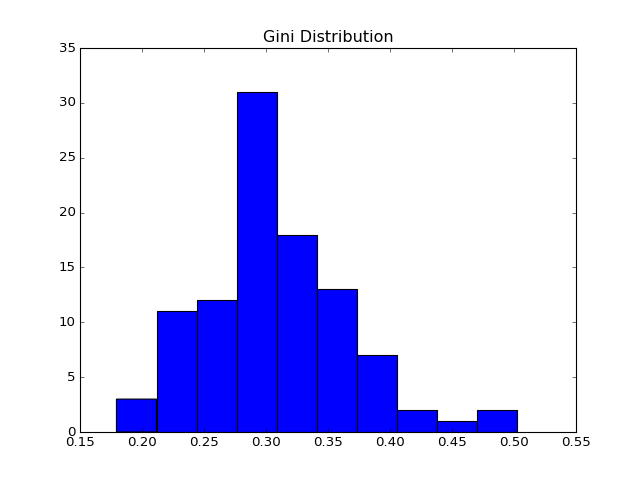

In [7]:
plt.hist(gini_list)
plt.title("Gini Distribution")
plt.show()

## Random Bounce Strategy

<IPython.core.display.Javascript object>


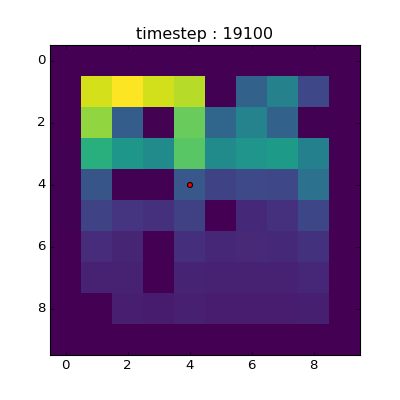

In [12]:
def animate(i):
    for t in  range(100):
        Sim.pos = Sim.random_bounce()
    Sim.observe()
    
Sim = grid_map(obst_dens = 0.15)
fig = plt.figure(figsize = (5,5))  
ani = animation.FuncAnimation(fig, animate, frames= 1000,
                    interval = 1, blit= True, repeat = False)

In [22]:
gini_list = []
for i in range(100):
    Sim = grid_map(obst_dens = 0.15)
    direction = None
    for _ in range(2000):
        Sim.random_bounce()
    gini_list.append(gini(Sim.tiles()))

<IPython.core.display.Javascript object>


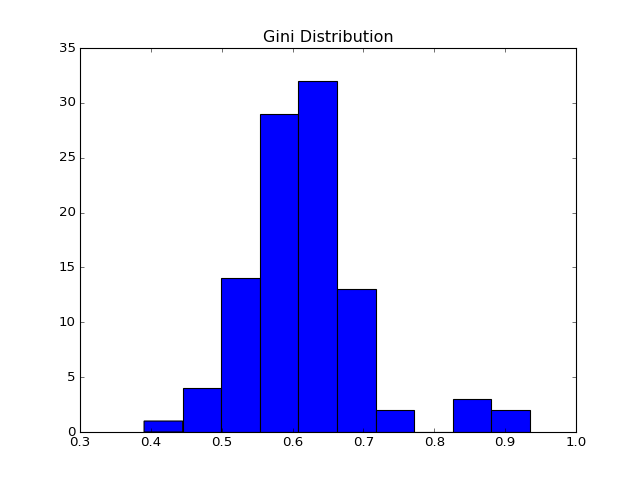

In [23]:
plt.hist(gini_list)
plt.title("Gini Distribution")
plt.show()

## Monte Carlo Localization

So far we have analized strategies that are map agnostic. Our robot decides were to move based on sensor information (for instance, whether there is an obstacle next of the robot in a given direction) without knowing the room's map or the robot's position in it. However, if the robot knew the map's layout and it's position in it, it could use a search algorithm to decide on the most optimal set of moves. For instance, we could use search to request for a state in which all tiles have been cleaned the same amount of times. Let us assume that our robot already knows the map, either because the user specified it or because the robot has previously followed a different routine to explore the whole map and identify obstacles. Let us see if the robot can succesfully use Monte Carlo Localization to find it's possition in the map.

#### Assumptions

1) The robot can measure the distance to the nearest obstacle/wall in the 4 directions perpendicular to the robot's sides (seen in the map as cardinal directions). 



In [101]:
Sim = grid_map(n = 10, obst_dens = 0.20, sensor_std = 0.00001 )
X, W = Sim.particle_filtering()
Sim.observe(X = X)

<IPython.core.display.Javascript object>


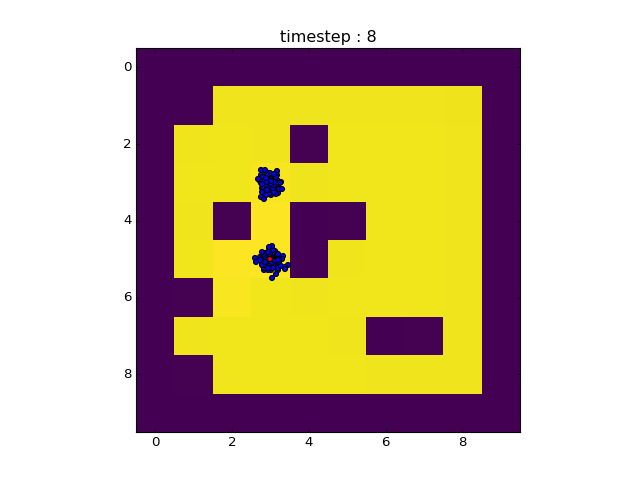

In [109]:
X, W = Sim.particle_filtering(X = X, W = W, steps = 1)
Sim.observe(X = X)

<IPython.core.display.Javascript object>


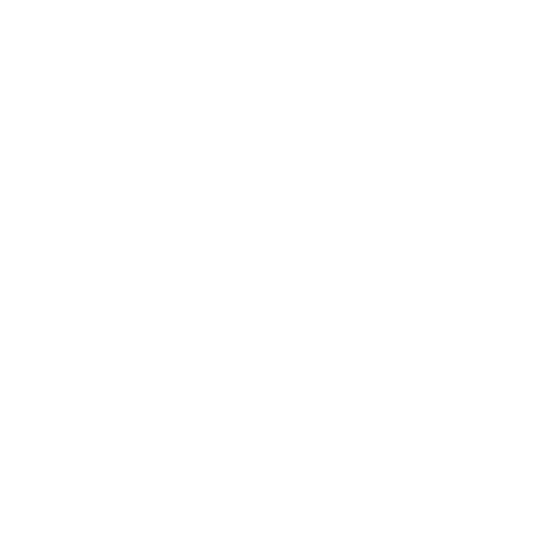

In [30]:
Sim = grid_map( n =5, obst_dens = 0.15)
X, W = Sim.particle_filtering(particles = 2)

def animate(i):
    for t in range(1):
        X, W = Sim.particle_filtering(X = X, W = W, steps = 1, particles= 2)
    Sim.observe(X = X)



fig = plt.figure(figsize = (7,7))  
ani = animation.FuncAnimation(fig, animate, frames= 1,
                    interval = 1, blit= True, repeat = True)